In [112]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from depth_anything_v2.dpt import DepthAnythingV2
import matplotlib

In [128]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits'  # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location=DEVICE))
model = model.to(DEVICE).eval()

# Colormap for depth visualization
cmap = matplotlib.colormaps.get_cmap('Spectral_r')

# Path to the specific image
image_path = "test_images/outside2/3.46m1m3m.jpeg"  # Replace with the path to your specific image


Using device: cpu


/tmp/ipykernel_12540/909664860.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_loca

Processing image: test_images/outside2/3.46m1m3m.jpeg


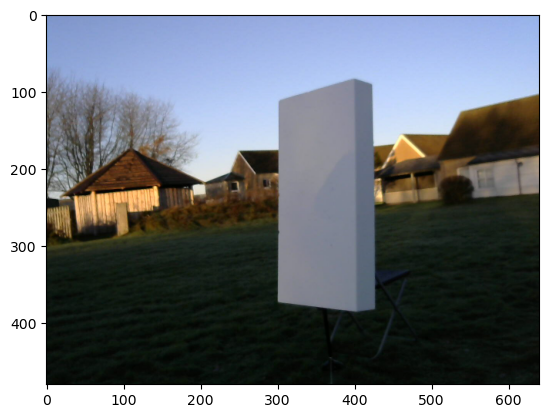

In [153]:
def preprocess_image(image):
    # Resize the image for consistent processing
    resized_image = cv2.resize(image, (640, 480))
    return resized_image

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
               
print(f"Processing image: {image_path}")

# Read the image
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Unable to read the image at {image_path}.")

# Preprocess the image
image = preprocess_image(image)

show_image(image)

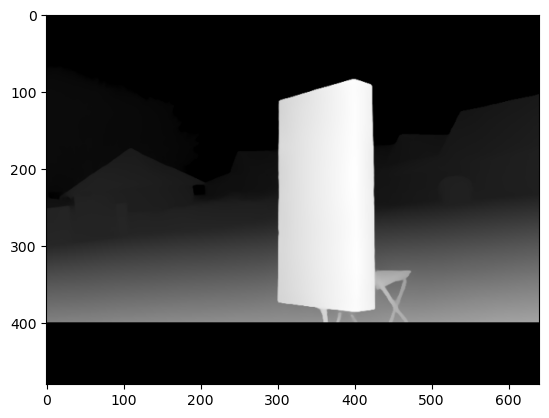

In [130]:
# Infer depth map
depth = model.infer_image(image)  # HxW raw depth map in numpy

# Normalize depth to range [0, 255]
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth_normalized = depth_normalized.astype(np.uint8)

# Get the dimensions of the image
height, width, channels = image.shape

# Calculate the starting row for the bottom third
start_row = height * 5 // 6

depth_normalized[start_row:height, :] = 0

show_image(depth_normalized)

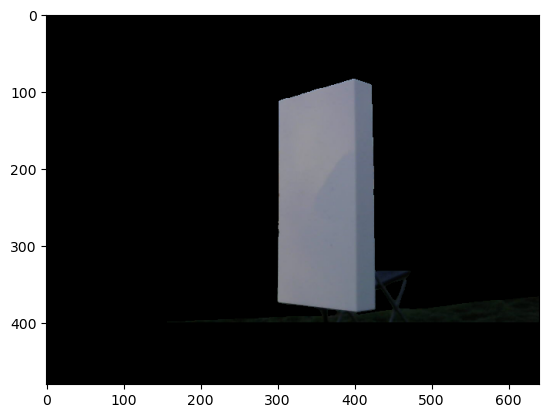

In [131]:
# Create a binary mask for the foreground
threshold = np.percentile(depth_normalized, 86)  # Set threshold for background removal
foreground_mask = depth_normalized >= threshold

# Apply the mask to the original image
masked_image = image.copy()
masked_image[~foreground_mask] = 0  # Set background pixels to black

show_image(masked_image)

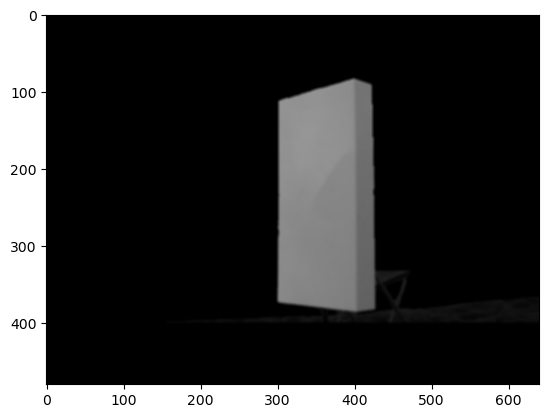

In [132]:
gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

# choose one, or a different function
blurred = cv2.GaussianBlur(gray, (5, 5), 2)
#blurred = cv2.bilateralFilter(gray, 9, 75, 75)

show_image(blurred)

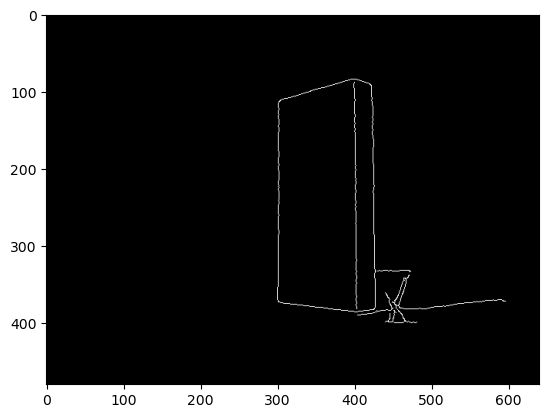

In [145]:
# Detect edges in the masked image
edges = cv2.Canny(blurred, 20, 60)

show_image(edges)

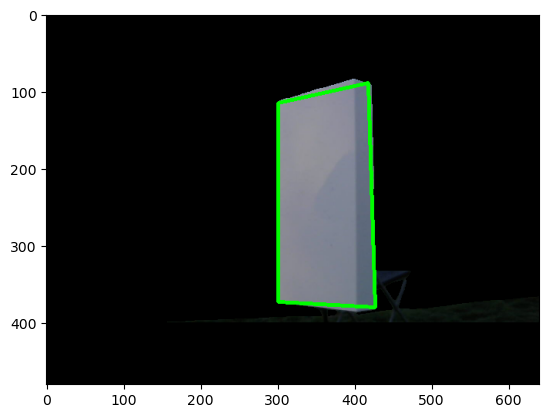

In [134]:
# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the masked image to draw the outline
outlined_image = masked_image.copy()
cv2.drawContours(outlined_image, contours, -1, (0,255,0), 3)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea) if contours else None

# Create a copy of the masked image to draw the outline
outlined_image = masked_image.copy()

if largest_contour is not None:
    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Draw the largest face outline
    cv2.drawContours(outlined_image, [approx_polygon], -1, (0, 255, 0), 3)  # Green outline

show_image(outlined_image)

test_images/outside2/3.46m1m3m.jpeg
[301 373]
[427 380]
[418  89]
[301 115]
(480, 640, 3)


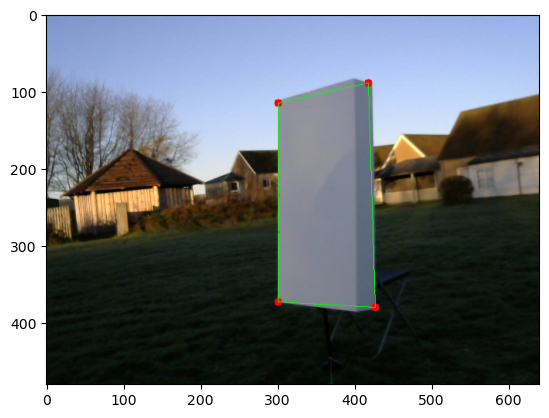

In [136]:
# drawing points
image_copy = image.copy()

for point in approx_polygon:
    x, y = point[0]
    cv2.circle(image_copy, (x, y), 5, (0, 0, 255), -1)

# drawing skewed rectangle
cv2.drawContours(image_copy, [approx_polygon], -1, (0, 255, 0))

print(image_path)
print(approx_polygon[2][0])
print(approx_polygon[3][0])
print(approx_polygon[0][0])
print(approx_polygon[1][0])

print(image_copy.shape)
show_image(image_copy)

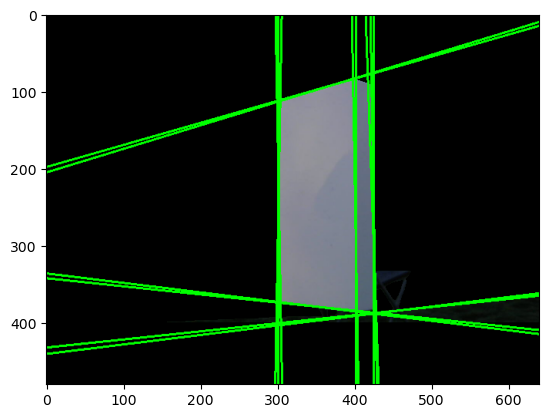

In [146]:
# Apply Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=60)  # Adjust the threshold for better results

# Create a copy of the masked image to draw lines
outlined_image = masked_image.copy() # !!! Try to use depth image

# Check if lines were detected
if lines is not None:
    for line in lines:
        rho, theta = line[0]  # rho is the distance, theta is the angle
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))  # Calculate the start point of the line
        y1 = int(y0 + 1000 * (a))  # Calculate the end point of the line
        x2 = int(x0 - 1000 * (-b))  # Calculate the start point of the line
        y2 = int(y0 - 1000 * (a))  # Calculate the end point of the line
        cv2.line(outlined_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw the line in green

# Show the resulting image
show_image(outlined_image)

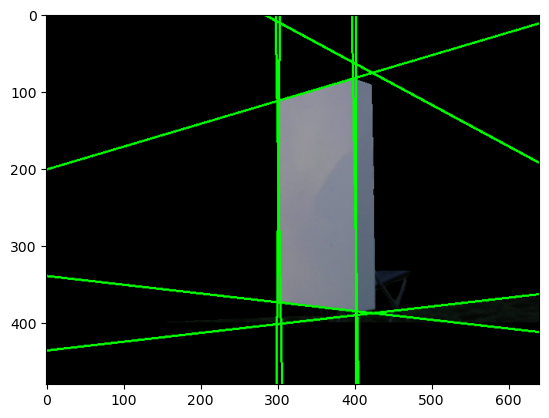

In [138]:
# https://stackoverflow.com/questions/43664328/remove-similar-lines-provided-by-hough-transform

def calculate_length(line):
    rho, theta = line
    return abs(rho)  # Length could be represented by the absolute value of rho

def unify_lines(lines, rho_threshold=10, theta_threshold=np.pi/180*10):
    grouped_lines = []

    # Step 1: Group similar lines
    for line in lines:
        for rho, theta in line:
            matched_group = None
            for group in grouped_lines:
                for u_rho, u_theta in group:
                    if (abs(u_rho - rho) < rho_threshold and abs(u_theta - theta) < theta_threshold) or \
                   (abs(u_rho + rho) < rho_threshold and abs(u_theta - (theta + np.pi)) % (2 * np.pi) < theta_threshold):
                        matched_group = group
                        break
                if matched_group:
                    break
            if matched_group:
                matched_group.append((rho, theta))
            else:
                grouped_lines.append([(rho, theta)])

    # Step 2: Compute weighted average for each group
    unified_lines = []
    for group in grouped_lines:
        total_weight = sum(calculate_length(line) for line in group)
        average_rho = sum(rho * calculate_length((rho, theta)) for rho, theta in group) / total_weight
        average_theta = sum(theta * calculate_length((rho, theta)) for rho, theta in group) / total_weight
        unified_lines.append((average_rho, average_theta))

    return np.array([[line] for line in unified_lines], dtype=np.float32)

# Hough Line Transform and visualization
edges = cv2.Canny(blurred, 20, 60)  # Replace with your actual edge-detection code
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=60)  # Detect lines

#show_image(edges)

# Group and unify similar lines
if lines is not None:
    lines = unify_lines(lines)  # Group similar lines

# Create a copy of the masked image to draw unified lines
outlined_image = masked_image.copy()

# Draw the unified lines
if lines is not None:
    for line in lines:
        rho, theta = line[0]  # Unified rho and theta
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))  # Calculate the start point of the line
        y1 = int(y0 + 1000 * (a))  # Calculate the end point of the line
        x2 = int(x0 - 1000 * (-b))  # Calculate the start point of the line
        y2 = int(y0 - 1000 * (a))  # Calculate the end point of the line
        cv2.line(outlined_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw the unified line in green

# Show the resulting image
show_image(outlined_image)


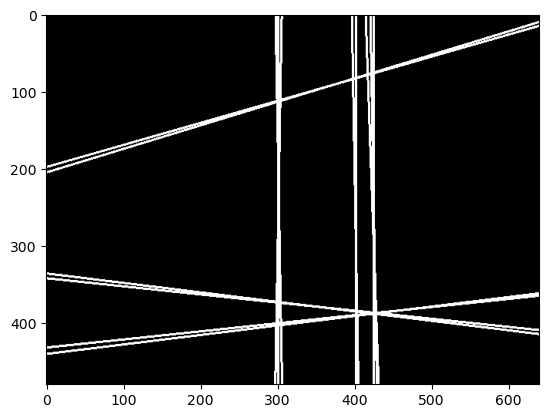

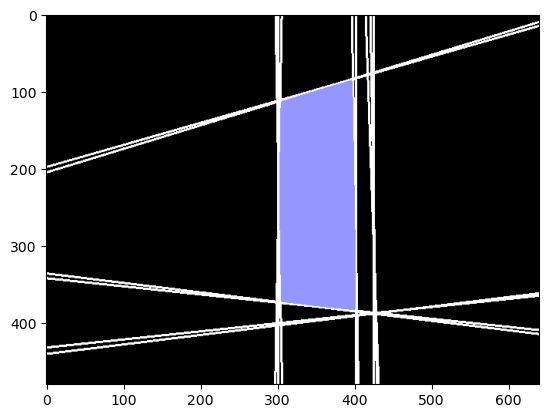

test_images/outside2/3.46m1m3m.jpeg
[306 373]
[401 382]
[396  86]
[305 114]


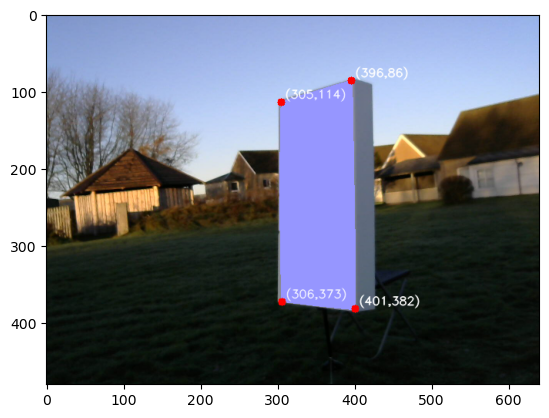

In [155]:
# Step 1: Create a blank image for Hough lines
blank_canvas = np.zeros_like(masked_image, dtype=np.uint8)

# Draw the Hough lines on the blank canvas
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(blank_canvas, (x1, y1), (x2, y2), (255, 255, 255), 2)  # Draw lines in white

# Step 2: Convert to greyscale
gray = cv2.cvtColor(blank_canvas, cv2.COLOR_BGR2GRAY)

show_image(blank_canvas)

# Step 3: Find contours to detect enclosed areas
contours, _ = cv2.findContours(gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Sort contours by area
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Check if there are at least two contours
if len(sorted_contours) > 1:
    second_largest_contour = sorted_contours[1]  # Get the second largest contour
    
    # Create an image to highlight the second largest contour
    highlighted_area = np.zeros_like(masked_image)

    # Calculate the area of the second largest contour
    area = cv2.contourArea(second_largest_contour)

    # Fill the second largest contour with a fixed color
    cv2.drawContours(blank_canvas, [second_largest_contour], -1, (255, 150, 150), thickness=cv2.FILLED)
    cv2.drawContours(image, [second_largest_contour], -1, (255, 150, 150), thickness=cv2.FILLED)

    show_image(blank_canvas)

    # Approximate the contour to find corner points
    epsilon = 0.02 * cv2.arcLength(second_largest_contour, True)  # Adjust epsilon for more/less simplification
    approx_corners = cv2.approxPolyDP(second_largest_contour, epsilon, True)

    # Highlight the corner points on the image
    for point in approx_corners:
        x, y = point[0]  # Extract the x, y coordinates
        cv2.circle(image, (x, y), 5, (0, 0, 255), -1)  # Draw red circles for corner points

    print(image_path)
    print(approx_corners[2][0])
    print(approx_corners[1][0])
    print(approx_corners[0][0])
    print(approx_corners[3][0])

    # Display the corner points as text
    for i, point in enumerate(approx_corners):
        x, y = point[0]
        cv2.putText(image, f"({x},{y})", (x + 5, y - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    # Step 5: Show the highlighted area with corner points
    show_image(image)
else:
    print("Not enough contours found to determine the second largest.")